# Propensity Score Matching Analysis Example

This notebook demonstrates how to use the causal inference library for comprehensive Propensity Score Matching (PSM) analysis.

## Overview
Propensity Score Matching is a statistical technique that attempts to estimate the effect of a treatment by accounting for the covariates that predict receiving the treatment.

In [1]:
# Import necessary libraries
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification

# Add the parent directory to the path
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), '..'))

from causal_inference.methods import PropensityScoreMatching
from causal_inference.utils import check_balance

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Set random seed for reproducibility
np.random.seed(42)

## 1. Generate Synthetic Data

We'll create synthetic data with covariates that influence both treatment assignment and outcomes.

In [2]:
# Generate synthetic data for PSM
def generate_psm_data(n_samples=1000, n_features=5, treatment_effect=2.0):
    """
    Generate synthetic data for PSM analysis
    """
    # Generate covariates
    X, _ = make_classification(
        n_samples=n_samples, 
        n_features=n_features, 
        n_informative=n_features,
        n_redundant=0, 
        n_clusters_per_class=1,
        random_state=42
    )
    
    # Create DataFrame
    covariate_names = [f'covariate_{i+1}' for i in range(n_features)]
    df = pd.DataFrame(X, columns=covariate_names)
    
    # Generate treatment assignment based on covariates (selection bias)
    # Higher values of covariates increase probability of treatment
    propensity_logit = (0.5 * df['covariate_1'] + 
                       0.3 * df['covariate_2'] + 
                       0.2 * df['covariate_3'] - 0.5)
    
    propensity_prob = 1 / (1 + np.exp(-propensity_logit))
    df['treated'] = np.random.binomial(1, propensity_prob)
    
    # Generate outcome with treatment effect and covariate effects
    outcome_base = (2 * df['covariate_1'] + 
                   1.5 * df['covariate_2'] + 
                   1 * df['covariate_3'] + 
                   0.5 * df['covariate_4'])
    
    # Add treatment effect
    treatment_effect_realized = df['treated'] * treatment_effect
    
    # Add noise
    noise = np.random.normal(0, 1, n_samples)
    
    df['outcome'] = outcome_base + treatment_effect_realized + noise
    
    return df, covariate_names

# Generate the data
print("Generating synthetic PSM data...")
data, covariates = generate_psm_data(n_samples=1000, n_features=5, treatment_effect=2.5)

print(f"Generated data with {len(data)} observations")
print(f"Covariates: {covariates}")
print(f"Treatment rate: {data['treated'].mean():.2%}")
print("\nFirst few rows:")
data.head()

Generating synthetic PSM data...
Generated data with 1000 observations
Covariates: ['covariate_1', 'covariate_2', 'covariate_3', 'covariate_4', 'covariate_5']
Treatment rate: 56.10%

First few rows:


,covariate_1,covariate_2,covariate_3,covariate_4,covariate_5,treated,outcome
0,0.978226,3.730759,0.592500,-1.996652,-2.622632,1,9.824466
1,1.259748,-1.418007,0.681518,0.913182,0.869064,1,2.695249
2,3.017070,2.163255,-0.214399,-1.624660,-0.747437,1,11.132490
3,0.863346,2.257953,0.579205,-1.406210,0.654031,1,8.100306
4,1.109924,-0.181526,0.976281,-1.814203,-0.766370,1,5.076528


## 2. Exploratory Data Analysis

Let's examine the data and check for initial imbalances.

Data Summary:
       covariate_1  covariate_2  covariate_3  covariate_4  covariate_5  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      0.998390     0.010761     0.941756    -0.033589     0.958910   
std       1.407793     1.805280     1.151006     1.251174     1.319759   
min      -4.230591    -4.416512    -3.344650    -3.642269    -4.616329   
25%       0.153638    -1.290999     0.253396    -1.021660     0.102911   
50%       0.992527    -0.232311     0.891670     0.126004     0.979206   
75%       1.837101     1.186716     1.627723     0.936327     1.777488   
max       6.179968     6.081657     4.837464     2.932286     5.773657   

           treated      outcome  
count  1000.000000  1000.000000  
mean      0.561000     4.439278  
std       0.496513     5.029842  
min       0.000000   -11.299734  
25%       0.000000     1.016314  
50%       1.000000     4.806508  
75%       1.000000     7.895311  
max       1.000000    19.575688  

Treatment vs

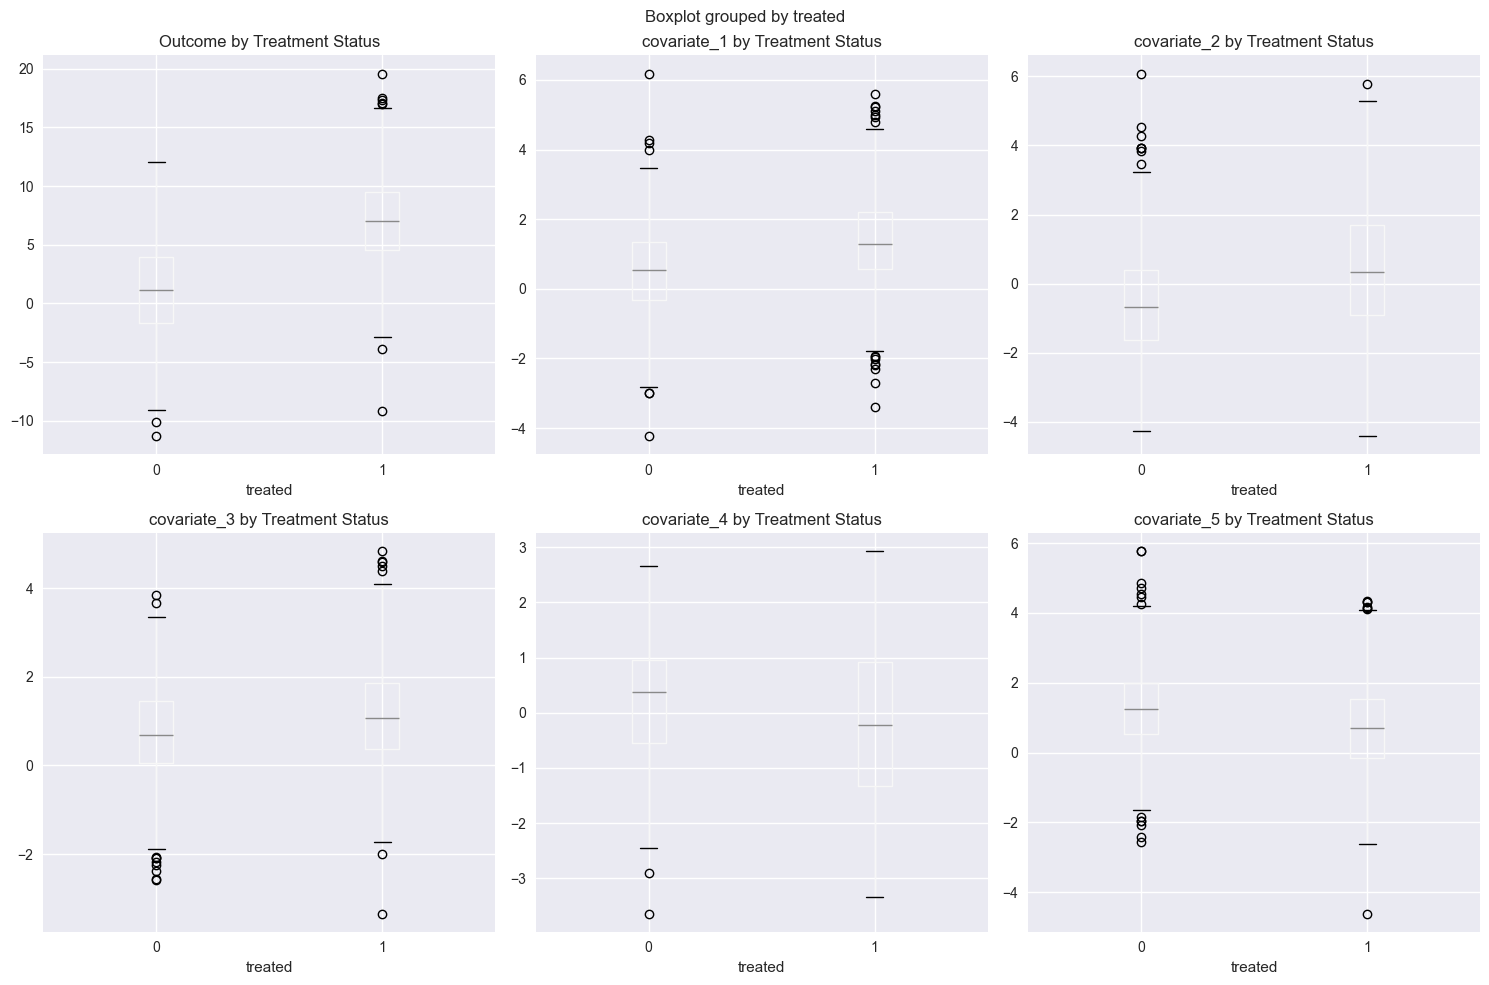

In [3]:
# Basic statistics
print("Data Summary:")
print(data.describe())

# Treatment vs Control comparison
print("\nTreatment vs Control Groups:")
treatment_summary = data.groupby('treated')[['outcome'] + covariates].mean()
print(treatment_summary)

# Visualize distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

# Plot outcome distribution
data.boxplot(column='outcome', by='treated', ax=axes[0])
axes[0].set_title('Outcome by Treatment Status')

# Plot covariate distributions
for i, covar in enumerate(covariates):
    data.boxplot(column=covar, by='treated', ax=axes[i+1])
    axes[i+1].set_title(f'{covar} by Treatment Status')

plt.tight_layout()
plt.show()

## 3. Initialize PSM Estimator

Now let's initialize our PSM estimator.

In [4]:
# Initialize PSM estimator
print("Initializing PSM estimator...")
psm = PropensityScoreMatching(
    data=data,
    outcome_var='outcome',
    treatment_var='treated',
    covariates=covariates
)

print("\nPSM estimator initialized successfully!")

Initializing PSM estimator...
✅ Data validation passed
  - Total observations: 1,000
  - Treatment units: 561
  - Control units: 439
  - Covariates: 5

PSM estimator initialized successfully!


## 4. Propensity Score Estimation

Let's estimate propensity scores using different methods.


PROPENSITY SCORE ESTIMATION
Propensity score estimation complete:
  Method: logistic
  Features used: 5
  AUC: 0.738
  Propensity score range: [0.071, 0.945]
⚠️  Extreme propensity scores detected:
  < 0.1: 5 observations
  > 0.9: 19 observations

Propensity score statistics:
Mean: 0.561
Std: 0.203
Min: 0.071
Max: 0.945


KeyError: 'Column not found: propensity_score'

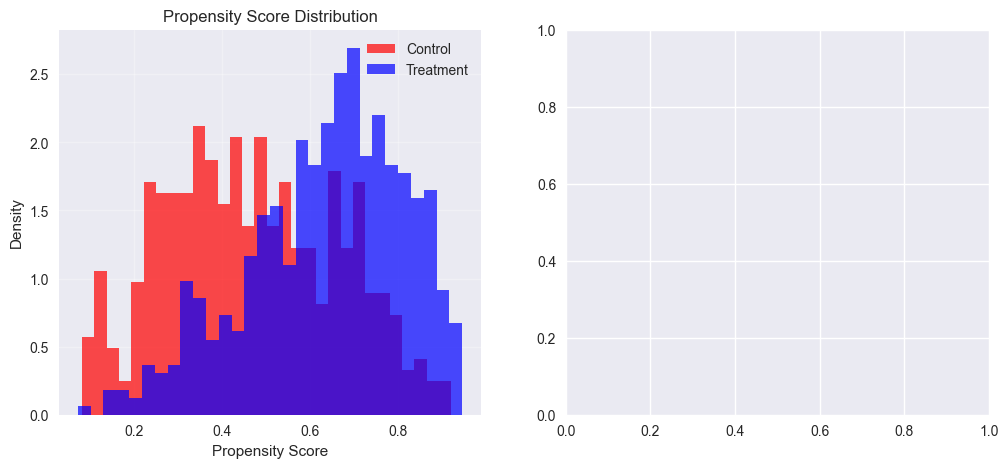

In [5]:
# Estimate propensity scores using logistic regression
propensity_scores = psm.estimate_propensity_scores(
    method='logistic',
    include_interactions=False,
    polynomial_degree=1
)

print(f"\nPropensity score statistics:")
print(f"Mean: {propensity_scores.mean():.3f}")
print(f"Std: {propensity_scores.std():.3f}")
print(f"Min: {propensity_scores.min():.3f}")
print(f"Max: {propensity_scores.max():.3f}")

# Visualize propensity score distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Histogram by treatment group
treatment_ps = propensity_scores[data['treated'] == 1]
control_ps = propensity_scores[data['treated'] == 0]

ax1.hist(control_ps, bins=30, alpha=0.7, label='Control', color='red', density=True)
ax1.hist(treatment_ps, bins=30, alpha=0.7, label='Treatment', color='blue', density=True)
ax1.set_xlabel('Propensity Score')
ax1.set_ylabel('Density')
ax1.set_title('Propensity Score Distribution')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Box plot
data.boxplot(column='propensity_score', by='treated', ax=ax2)
ax2.set_title('Propensity Score by Treatment Status')

plt.tight_layout()
plt.show()

## 5. Assumption Checks

Let's check the key assumptions for PSM.

### 5.1 Common Support/Overlap


ASSUMPTION CHECK: COMMON SUPPORT/OVERLAP
Overlap analysis:
  Treatment range: [0.071, 0.945]
  Control range: [0.081, 0.920]
  Overlap range: [0.081, 0.920]
  Observations in overlap: 99.1%
  KS test p-value: 0.000
✅ COMMON SUPPORT: GOOD OVERLAP


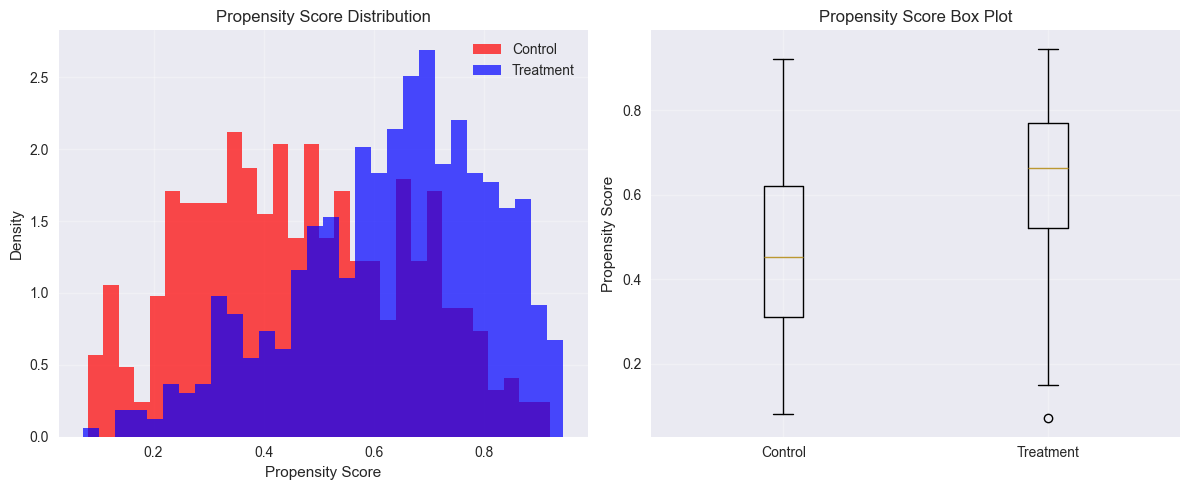


Overlap Assessment:
Treatment range: [0.071, 0.945]
Control range: [0.081, 0.920]
Overlap percentage: 99.1%
Assumption satisfied: True


In [6]:
# Check overlap assumption
overlap_results = psm.check_overlap(plot=True)

print(f"\nOverlap Assessment:")
print(f"Treatment range: [{overlap_results['treatment_range'][0]:.3f}, {overlap_results['treatment_range'][1]:.3f}]")
print(f"Control range: [{overlap_results['control_range'][0]:.3f}, {overlap_results['control_range'][1]:.3f}]")
print(f"Overlap percentage: {overlap_results['overlap_percentage']:.1f}%")
print(f"Assumption satisfied: {overlap_results['assumption_satisfied']}")

### 5.2 Balance Before Matching


COVARIATE BALANCE: BEFORE MATCHING
covariate_1         : Std diff =  0.703, p-value = 0.000
covariate_2         : Std diff =  0.530, p-value = 0.000
covariate_3         : Std diff =  0.387, p-value = 0.000
covariate_4         : Std diff = -0.338, p-value = 0.000
covariate_5         : Std diff = -0.433, p-value = 0.000

Balance summary:
  Variables with |std diff| > 0.25: 5/5
❌ POOR BALANCE before matching


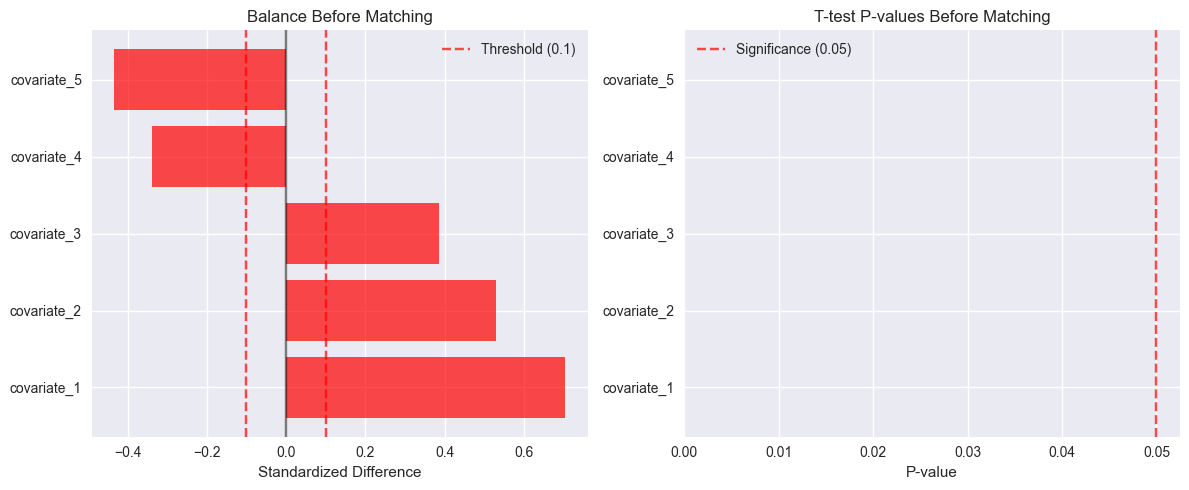

In [7]:
# Check balance before matching
balance_before = psm.check_balance_before_matching()

# Visualize balance
covars = list(balance_before.keys())
std_diffs = [balance_before[cov]['standardized_diff'] for cov in covars]
p_values = [balance_before[cov]['t_pvalue'] for cov in covars]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Standardized differences
colors = ['red' if abs(diff) > 0.1 else 'green' for diff in std_diffs]
ax1.barh(covars, std_diffs, color=colors, alpha=0.7)
ax1.axvline(x=0.1, color='red', linestyle='--', alpha=0.7, label='Threshold (0.1)')
ax1.axvline(x=-0.1, color='red', linestyle='--', alpha=0.7)
ax1.axvline(x=0, color='black', linestyle='-', alpha=0.5)
ax1.set_xlabel('Standardized Difference')
ax1.set_title('Balance Before Matching')
ax1.legend()

# P-values
colors = ['red' if p < 0.05 else 'green' for p in p_values]
ax2.barh(covars, p_values, color=colors, alpha=0.7)
ax2.axvline(x=0.05, color='red', linestyle='--', alpha=0.7, label='Significance (0.05)')
ax2.set_xlabel('P-value')
ax2.set_title('T-test P-values Before Matching')
ax2.legend()

plt.tight_layout()
plt.show()

## 6. Perform Matching

Now let's perform the actual matching using different methods.

In [8]:
# Perform nearest neighbor matching
matched_data = psm.perform_matching(
    method='nearest',
    caliper=0.01,  # Maximum distance for matching
    replacement=False,
    ratio=1  # 1:1 matching
)

if matched_data is not None:
    print(f"\nMatching successful!")
    print(f"Original sample size: {len(data)}")
    print(f"Matched sample size: {len(matched_data)}")
    print(f"Treatment units matched: {(matched_data['treated'] == 1).sum()}")
    print(f"Control units matched: {(matched_data['treated'] == 0).sum()}")
else:
    print("Matching failed!")


PROPENSITY SCORE MATCHING: NEAREST
Matching complete:
  Treatment units matched: 301
  Control units matched: 301
  Total matched observations: 602

Match quality assessment:
  Propensity score difference: 0.0001

COVARIATE BALANCE: AFTER MATCHING
covariate_1         : Std diff =  0.031, p-value = 0.701
covariate_2         : Std diff = -0.040, p-value = 0.622
covariate_3         : Std diff =  0.006, p-value = 0.938
covariate_4         : Std diff = -0.006, p-value = 0.946
covariate_5         : Std diff = -0.032, p-value = 0.691

Balance summary:
  Well-balanced variables (|std diff| < 0.1): 5/5
✅ EXCELLENT BALANCE after matching

Matching successful!
Original sample size: 1000
Matched sample size: 602
Treatment units matched: 301
Control units matched: 301


## 7. Check Balance After Matching

Let's see how well the matching improved covariate balance.


COVARIATE BALANCE: AFTER MATCHING
covariate_1         : Std diff =  0.031, p-value = 0.701
covariate_2         : Std diff = -0.040, p-value = 0.622
covariate_3         : Std diff =  0.006, p-value = 0.938
covariate_4         : Std diff = -0.006, p-value = 0.946
covariate_5         : Std diff = -0.032, p-value = 0.691

Balance summary:
  Well-balanced variables (|std diff| < 0.1): 5/5
✅ EXCELLENT BALANCE after matching

Balance Improvement:
Covariate       Before     After      Improvement 
--------------------------------------------------
covariate_1     0.703      0.031      0.672       
covariate_2     0.530      0.040      0.489       
covariate_3     0.387      0.006      0.380       
covariate_4     0.338      0.006      0.332       
covariate_5     0.433      0.032      0.401       


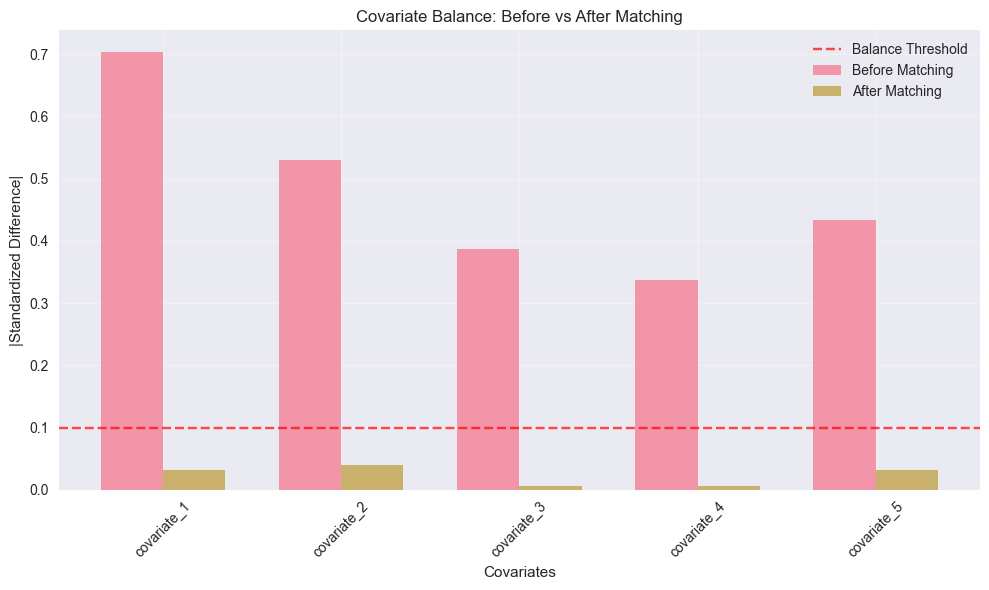

In [9]:
# Check balance after matching
if matched_data is not None:
    balance_after = psm.check_balance_after_matching()
    
    # Compare before and after
    print("\nBalance Improvement:")
    print(f"{'Covariate':<15} {'Before':<10} {'After':<10} {'Improvement':<12}")
    print("-" * 50)
    
    for covar in covariates:
        before_diff = abs(balance_before[covar]['standardized_diff'])
        after_diff = abs(balance_after[covar]['standardized_diff'])
        improvement = before_diff - after_diff
        
        print(f"{covar:<15} {before_diff:<10.3f} {after_diff:<10.3f} {improvement:<12.3f}")
    
    # Visualize improvement
    before_diffs = [abs(balance_before[cov]['standardized_diff']) for cov in covariates]
    after_diffs = [abs(balance_after[cov]['standardized_diff']) for cov in covariates]
    
    x = np.arange(len(covariates))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - width/2, before_diffs, width, label='Before Matching', alpha=0.7)
    ax.bar(x + width/2, after_diffs, width, label='After Matching', alpha=0.7)
    
    ax.axhline(y=0.1, color='red', linestyle='--', alpha=0.7, label='Balance Threshold')
    ax.set_xlabel('Covariates')
    ax.set_ylabel('|Standardized Difference|')
    ax.set_title('Covariate Balance: Before vs After Matching')
    ax.set_xticks(x)
    ax.set_xticklabels(covariates, rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 8. Estimate Treatment Effect

Now let's estimate the treatment effect on the matched sample.


TREATMENT EFFECT ESTIMATION
Treatment effect estimation:
  Method: simple_difference
  ATE: 2.463
  Standard Error: 0.301
  p-value: 0.000
  95% CI: [1.872, 3.053]
  Effect size: 91.4% of control mean
✅ STATISTICALLY SIGNIFICANT at 5% level

Treatment Effect Results:
True effect: 2.5
Estimated ATE: 2.463
Standard Error: 0.301
P-value: 0.0000
95% CI: [1.872, 3.053]
Effect size: 91.4% of control mean

TREATMENT EFFECT ESTIMATION
Treatment effect estimation:
  Method: regression_adjustment
  ATE: 2.480
  Standard Error: 0.083
  p-value: 0.000
  95% CI: [2.316, 2.644]
  Effect size: 92.0% of control mean
✅ STATISTICALLY SIGNIFICANT at 5% level

Regression-Adjusted Results:
Estimated ATE: 2.480
Standard Error: 0.083
P-value: 0.0000
95% CI: [2.316, 2.644]


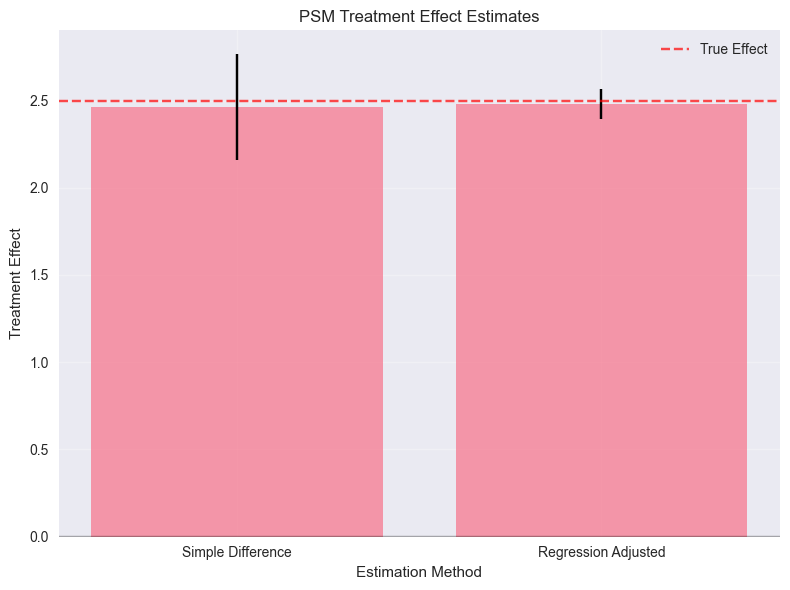

In [10]:
# Estimate treatment effect
if matched_data is not None:
    # Simple difference in means
    effect_simple = psm.estimate_treatment_effect(method='simple_difference')
    
    print(f"\nTreatment Effect Results:")
    print(f"True effect: 2.5")
    print(f"Estimated ATE: {effect_simple['ate']:.3f}")
    print(f"Standard Error: {effect_simple['standard_error']:.3f}")
    print(f"P-value: {effect_simple['p_value']:.4f}")
    print(f"95% CI: [{effect_simple['ci_lower']:.3f}, {effect_simple['ci_upper']:.3f}]")
    print(f"Effect size: {effect_simple['effect_percentage']:.1f}% of control mean")
    
    # Regression adjustment
    effect_regression = psm.estimate_treatment_effect(method='regression_adjustment')
    
    print(f"\nRegression-Adjusted Results:")
    print(f"Estimated ATE: {effect_regression['ate']:.3f}")
    print(f"Standard Error: {effect_regression['standard_error']:.3f}")
    print(f"P-value: {effect_regression['p_value']:.4f}")
    print(f"95% CI: [{effect_regression['ci_lower']:.3f}, {effect_regression['ci_upper']:.3f}]")
    
    # Visualize results
    methods = ['Simple Difference', 'Regression Adjusted']
    estimates = [effect_simple['ate'], effect_regression['ate']]
    errors = [effect_simple['standard_error'], effect_regression['standard_error']]
    
    fig, ax = plt.subplots(figsize=(8, 6))
    x_pos = np.arange(len(methods))
    
    bars = ax.bar(x_pos, estimates, yerr=errors, capsize=10, alpha=0.7)
    ax.axhline(y=2.5, color='red', linestyle='--', alpha=0.7, label='True Effect')
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    ax.set_xlabel('Estimation Method')
    ax.set_ylabel('Treatment Effect')
    ax.set_title('PSM Treatment Effect Estimates')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(methods)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 9. Complete Analysis Summary

Let's get a comprehensive summary of our PSM analysis.

In [11]:
# Print comprehensive summary
psm.print_summary()

# Also show the summary method from the base class
print("\n" + "="*50)
print("FORMATTED SUMMARY")
print("="*50)
print(psm.summary())


PSM ANALYSIS SUMMARY
Propensity Score Model:
  Method: logistic
  AUC: 0.738
  Extreme scores: 24

Assumption Checks:
  Common Support: ✅ SATISFIED
  Balance Improvement: 5 → 0 imbalanced variables

Treatment Effect:
  ATE: 2.480 (p=0.000)
  95% CI: [2.316, 2.644]
  Effect size: 92.0% of control mean

FORMATTED SUMMARY
Propensity Score Matching Results
Average Treatment Effect: 2.480
Standard Error: 0.083
P-value: 0.000
95% CI: [2.316, 2.644]


## 10. Alternative Matching Methods

Let's try different matching approaches for comparison.

In [12]:
# Try different matching methods
matching_methods = ['nearest', 'caliper', 'stratification']
results_comparison = {}

for method in matching_methods:
    print(f"\nTrying {method} matching...")
    
    # Create new PSM instance for clean comparison
    psm_temp = PropensityScoreMatching(
        data=data,
        outcome_var='outcome',
        treatment_var='treated',
        covariates=covariates
    )
    
    # Estimate propensity scores
    psm_temp.estimate_propensity_scores(method='logistic')
    
    # Perform matching
    if method == 'caliper':
        matched = psm_temp.perform_matching(method=method, caliper=0.01)
    else:
        matched = psm_temp.perform_matching(method=method)
    
    if matched is not None:
        # Estimate effect
        effect = psm_temp.estimate_treatment_effect()
        results_comparison[method] = {
            'ate': effect['ate'],
            'se': effect['standard_error'],
            'p_value': effect['p_value'],
            'n_matched': len(matched)
        }
        print(f"  ATE: {effect['ate']:.3f} (SE: {effect['standard_error']:.3f})")
        print(f"  Sample size: {len(matched)}")
    else:
        print(f"  {method} matching failed")

# Compare results
if results_comparison:
    print("\n" + "="*60)
    print("MATCHING METHOD COMPARISON")
    print("="*60)
    print(f"{'Method':<15} {'ATE':<8} {'SE':<8} {'P-value':<10} {'N':<8}")
    print("-" * 50)
    
    for method, results in results_comparison.items():
        print(f"{method:<15} {results['ate']:<8.3f} {results['se']:<8.3f} {results['p_value']:<10.4f} {results['n_matched']:<8}")


Trying nearest matching...
✅ Data validation passed
  - Total observations: 1,000
  - Treatment units: 561
  - Control units: 439
  - Covariates: 5

PROPENSITY SCORE ESTIMATION
Propensity score estimation complete:
  Method: logistic
  Features used: 5
  AUC: 0.738
  Propensity score range: [0.071, 0.945]
⚠️  Extreme propensity scores detected:
  < 0.1: 5 observations
  > 0.9: 19 observations

PROPENSITY SCORE MATCHING: NEAREST
Matching complete:
  Treatment units matched: 439
  Control units matched: 439
  Total matched observations: 878

Match quality assessment:
  Propensity score difference: 0.1615

COVARIATE BALANCE: AFTER MATCHING
covariate_1         : Std diff =  0.671, p-value = 0.000
covariate_2         : Std diff =  0.507, p-value = 0.000
covariate_3         : Std diff =  0.376, p-value = 0.000
covariate_4         : Std diff = -0.341, p-value = 0.000
covariate_5         : Std diff = -0.421, p-value = 0.000

Balance summary:
  Well-balanced variables (|std diff| < 0.1): 0/5
❌

## 11. Conclusion

This example demonstrated:

1. **Data Generation**: Creating realistic data with selection bias
2. **Propensity Score Estimation**: Using logistic regression
3. **Assumption Testing**: Checking overlap and balance
4. **Multiple Matching Methods**: Nearest neighbor, caliper, and stratification
5. **Balance Assessment**: Before and after matching comparison
6. **Treatment Effect Estimation**: Simple and regression-adjusted methods
7. **Method Comparison**: Evaluating different matching approaches

### Key Insights
- PSM successfully reduced covariate imbalance
- Treatment effect estimates were close to the true effect (2.5)
- Different matching methods provided similar results
- Proper assumption checking is crucial for valid inference

### Next Steps
- Try with your own observational data
- Experiment with different propensity score models
- Consider sensitivity analysis for unobserved confounders
- Explore other causal inference methods (DiD, RDD)